In [14]:
# %cd ../src
# %ls
# %cd ..

In [15]:
import sys
sys.path.insert(1, '..')
from utils import timeSteps2stepSize

this version supports over damped and underdamped dynamics

In [16]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import optax

import time

import os
import pickle

import matplotlib.pyplot as plt

from torch.utils import data
from torch.utils.data import Dataset

# print("the device used is", jax.devices(), jax.default_backend())
# print(jax.device_count())

# Dataloader and metaparameters

In [17]:
seed = 0
key = random.PRNGKey(seed)
rng = key
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 2000

dimension = 2
T_max = 1.0

num_training_iterations = 40_000

print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

the device used is [gpu(id=0)] gpu
1


In [18]:
def generateBatchPoints(key, distribution = 'plus_sign', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )

    return(positions[...,None])

class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])
    
    

In [19]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [20]:
rng , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

## useful functions

In [21]:
beta = 6.0

gamma = 0.1
Gamma = 0.02

M = 0.25 # Magic value from paper 
nu = 2*jnp.sqrt(M**(-1)) + Gamma # Critically or Non critically damped regime
BETA = lambda t : t*beta
print(" values    :   nu ",nu,"  Gamma ",Gamma,"  M ",M)
if 4*M**(-1) != (Gamma - nu)**2 :
    print("NON CRITICALLY DAMPED REGIME !!")
else :
    print("CRITICALLY DAMPED REGIME !!")


 values    :   nu  4.02   Gamma  0.02   M  0.25
CRITICALLY DAMPED REGIME !!


In [22]:
def timeIndeces2RealTime(time_indices ) :
    return( time_indices *1.0/num_timesteps)

In [23]:
# defining the Sigma in a non-critical general way. We use different notations here.

# TODO change those values they are arbitrary 
Sigma_xx_0 = 0.
Sigma_vv_0 = 0.1

A1 = 0

# check if we are in the critically damped regime
if 4*M**(-1) != (Gamma - nu)**2 :
    Sigma_xx = lambda t : (1/(2*M*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(2*jnp.exp((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma+ nu)))/(2*M))*M*(-4 + M*(Gamma- nu)**2) + 2*Sigma_vv_0 - 4*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + M*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma- nu))*(Gamma- nu)*(-1 + Sigma_xx_0) - 2*M*Sigma_xx_0 + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/ M)*(2*Sigma_vv_0 - M*(Gamma- nu)*(jnp.sqrt( M*(-4 + M*(Gamma- nu)**2)) + M*(-Gamma+ nu))*(-1 + Sigma_xx_0) - 2*M*Sigma_xx_0))
    Sigma_xv = lambda t : (1/(2*M*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(-jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_vv_0 + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_vv_0 + M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) - 2*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + M*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_xx_0 -jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*M*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_xx_0)
    Sigma_vv = lambda t : -(1/(2*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(-2*jnp.exp((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma+ nu)))/(2*M))*M*(-4 + M*(Gamma- nu)**2) + M**2*(Gamma- nu)**2 + (2 + jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*(Gamma- nu))*Sigma_vv_0 + 4*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) - M*((Gamma- nu)*(jnp.sqrt( M*(-4 + M*(Gamma- nu)**2)) + Gamma*Sigma_vv_0 - nu*Sigma_vv_0) + 2*Sigma_xx_0) + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*(M**2*(Gamma- nu)**2 + 2*Sigma_vv_0 + jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*(-Gamma+ nu)*Sigma_vv_0 + M*(Gamma- nu)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) - Gamma*Sigma_vv_0 + nu*Sigma_vv_0) - 2*M*Sigma_xx_0))

    def mu_global_HSM(t_batch, x_0_batch, v_0_batch = None) :
        """ 
        input :
        - t_batch : (batch_size,)
        - x_0_batch : (batch_size,dimension,1) or (batch_size,dimension)
        - v_0_batch (optional) : (batch_size,dimension,1) or (batch_size,dimension)
        output :
        - mu : (batch_size,2,dimension)
        """
        if v_0_batch is None :
            v_0_batch = jnp.zeros(x_0_batch.shape)
        
        x0 = x_0_batch.reshape(batch_size, dimension)
        v0 = v_0_batch.reshape(batch_size, dimension)
        t = t_batch.reshape((-1,1))
        print("ee",BETA(t).shape)

        mu_v = (jnp.exp(-((BETA(t)*(jnp.sqrt(-4 + M*(Gamma - nu)**2) + jnp.sqrt(M)*(Gamma + nu)))/( 4*jnp.sqrt(M))))*((1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/(2*jnp.sqrt(M))))*v0*jnp.sqrt(-4 + M*(Gamma - nu)**2) - (-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*jnp.sqrt(M)*(2*x0 + v0*(-Gamma + nu))))/( 2*jnp.sqrt(-4 + M*(Gamma - nu)**2) )
        mu_x = (jnp.exp(-((BETA(t)*(jnp.sqrt(-4 + M*(Gamma - nu)**2) + jnp.sqrt(M)*(Gamma + nu)))/( 4*jnp.sqrt(M))))*(2*(-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*v0 + (1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/(2*jnp.sqrt(M))))*jnp.sqrt(M)*x0*jnp.sqrt(-4 + M*(Gamma - nu)**2) - (-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*M*x0*(Gamma - nu)))/( 2*jnp.sqrt(M)*jnp.sqrt(-4 + M*(Gamma - nu)**2))
        print(mu_v.shape)
        print(mu_x.shape)
        
        # (2, batch_size ,  dim) -> (batch_size, 2, dim)
        return jnp.array([mu_x, mu_v ]).transpose( (1,0,2) )
else :

    A1 = 1./(4*M)
    A2 = M**(-2)/8.
    A2 = M**(-2)/4. # TODO REVOIR !!
    A3 = (nu-Gamma)/2.
    A4 = -M**(-1)/2. 
    A5 = (Gamma-nu)/2.
    C1 = (Gamma-nu)/8.
    C2 = (Gamma-nu)**3/32.
    C3 = -1/2.
    C4 = M**(-1)/2.
    C5 = (nu-Gamma)/4.
    D1 = 1/4.
    D2 = M**(-1)/4.
    D3 = (Gamma-nu)/2.
    D4 = -1/2.
    D5 = M*(nu-Gamma)/4.
    Sigma_xx = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( A1*BETA(t)**2*Sigma_xx_0 + A2*BETA(t)**2*Sigma_vv_0 + A3*BETA(t)*Sigma_xx_0 + A4*BETA(t)**2 + A5*BETA(t) + (jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_xx_0)
    Sigma_xv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( C1*BETA(t)**2*Sigma_xx_0 + C2*BETA(t)**2*Sigma_vv_0 + C3*BETA(t)*Sigma_xx_0 + C4*BETA(t)*Sigma_vv_0 + C5*BETA(t)**2)
    Sigma_vv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( D1*BETA(t)**2*Sigma_xx_0 + D2*BETA(t)**2*Sigma_vv_0 + D3*BETA(t)*Sigma_vv_0 + D4*BETA(t)**2 + D5*BETA(t) + M*(jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_vv_0)

    # Sigma_xx = lambda t : 1+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8-BETA(t)*(-4+BETA(t)*(Gamma-nu))*(Gamma-nu))+1/64*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(Gamma-nu)**4*Sigma_vv_0+1/16*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-4+BETA(t)*(Gamma-nu))**2* Sigma_xx_0
    # Sigma_xv = lambda t : 1/4*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(-Gamma+nu)+1/32*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(4+BETA(t)*(Gamma-nu))*(Gamma-nu)**2* Sigma_vv_0+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(-4+BETA(t)*(Gamma-nu))*Sigma_xx_0
    # Sigma_vv = lambda t : (jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8+8*jnp.exp(1/2*BETA(t)*(Gamma+nu))-BETA(t)* (4+BETA(t)*(Gamma-nu))*(Gamma-nu)))/(2*(Gamma-nu)**2)+1/16*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*(4+BETA(t)*(Gamma-nu))**2*Sigma_vv_0+1/4*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*BETA(t)**2*Sigma_xx_0

    def mu_global_HSM(t_batch, x_0_batch, v_0_batch = None) :
        """ 
        input :
        - t_batch : (batch_size,)
        - x_0_batch : (batch_size,dimension,1) or (batch_size,dimension)
        - v_0_batch (optional) : (batch_size,dimension,1) or (batch_size,dimension)
        output :
        - mu : (batch_size,2,dimension)
        """
        if v_0_batch is None :
            v_0_batch = jnp.zeros(x_0_batch.shape)
        
        x0 = x_0_batch.reshape(batch_size, dimension)
        v0 = v_0_batch.reshape(batch_size, dimension)
        t = t_batch.reshape((-1,1))
        print("ee",BETA(t).shape)

        mu_v = jnp.exp(-(BETA(t)*(Gamma + nu)/4.0))*(  (nu-Gamma)/4.*BETA(t)*x0 + (nu-Gamma)**2/8.*BETA(t)*v0 + x0  )
        mu_x = jnp.exp(-(BETA(t)*(Gamma + nu)/4.0))*(  -1/2.*BETA(t)*x0 + (Gamma-nu)/4.*BETA(t)*v0 + v0 )
        print(mu_v.shape)
        print(mu_x.shape)
        
        # (2, batch_size ,  dim) -> (batch_size, 2, dim)
        return jnp.array([mu_x, mu_v ]).transpose( (1,0,2) )


(100,)


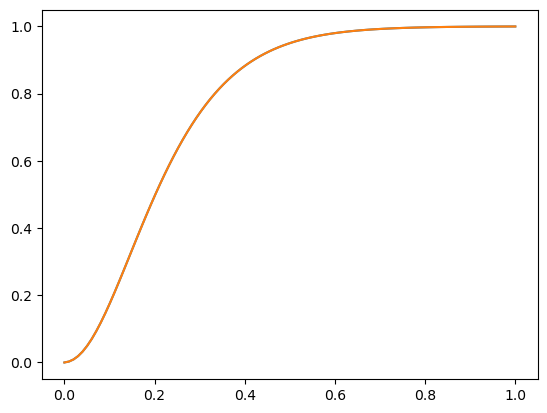

0.99961543 0.9996153


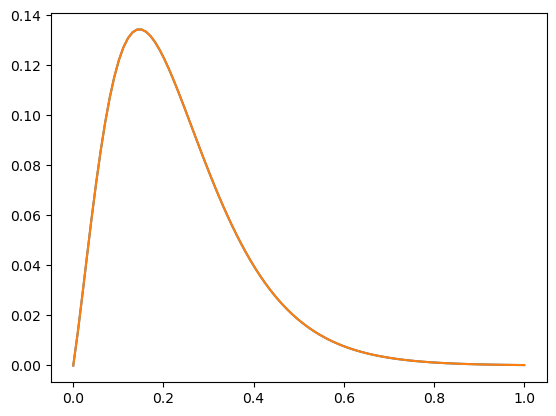

0.00016348285 0.00016348287


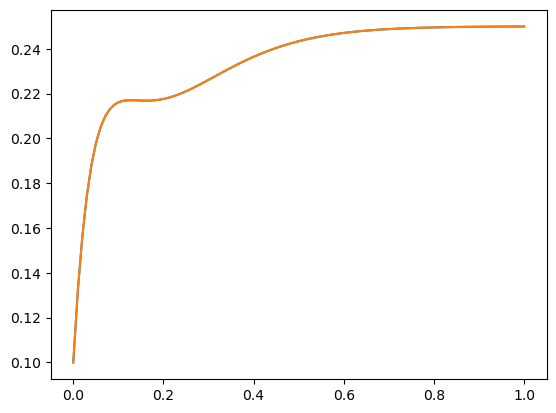

0.24993055 0.24993055


In [24]:
# Study of weird incosistencies between my result and the paper's 

A1 = 1./(4*M)
A2 = M**(-2)/8.
A2 = M**(-2)/4. # TODO REVOIR !!
A3 = (nu-Gamma)/2.
A4 = -M**(-1)/2. 
A5 = (Gamma-nu)/2.
C1 = (Gamma-nu)/8.
C2 = (Gamma-nu)**3/32.
C3 = -1/2.
C4 = M**(-1)/2.
C5 = (nu-Gamma)/4.
D1 = 1/4.
D2 = M**(-1)/4.
D3 = (Gamma-nu)/2.
D4 = -1/2.
D5 = M*(nu-Gamma)/2.
Sigma_xx = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( A1*BETA(t)**2*Sigma_xx_0 + A2*BETA(t)**2*Sigma_vv_0 + A3*BETA(t)*Sigma_xx_0 + A4*BETA(t)**2 + A5*BETA(t) + (jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_xx_0)
Sigma_xv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( C1*BETA(t)**2*Sigma_xx_0 + C2*BETA(t)**2*Sigma_vv_0 + C3*BETA(t)*Sigma_xx_0 + C4*BETA(t)*Sigma_vv_0 + C5*BETA(t)**2)
Sigma_vv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( D1*BETA(t)**2*Sigma_xx_0 + D2*BETA(t)**2*Sigma_vv_0 + D3*BETA(t)*Sigma_vv_0 + D4*BETA(t)**2 + D5*BETA(t) + M*(jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_vv_0)

Sigma_xx_2 = lambda t : 1+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8-BETA(t)*(-4+BETA(t)*(Gamma-nu))*(Gamma-nu))+1/64*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(Gamma-nu)**4*Sigma_vv_0+1/16*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-4+BETA(t)*(Gamma-nu))**2* Sigma_xx_0
Sigma_xv_2 = lambda t : 1/4*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(-Gamma+nu)+1/32*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(4+BETA(t)*(Gamma-nu))*(Gamma-nu)**2* Sigma_vv_0+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(-4+BETA(t)*(Gamma-nu))*Sigma_xx_0
Sigma_vv_2 = lambda t : (jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8+8*jnp.exp(1/2*BETA(t)*(Gamma+nu))-BETA(t)* (4+BETA(t)*(Gamma-nu))*(Gamma-nu)))/(2*(Gamma-nu)**2)+1/16*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*(4+BETA(t)*(Gamma-nu))**2*Sigma_vv_0+1/4*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*BETA(t)**2*Sigma_xx_0

t = np.linspace(0,1,100)
print(t.shape)
plt.plot(t, Sigma_xx(t))
plt.plot(t, Sigma_xx_2(t))
plt.show()
print( Sigma_xx(1.),Sigma_xx_2(1.))

plt.plot(t, Sigma_xv(t))
plt.plot(t, Sigma_xv_2(t))
plt.show()
print( Sigma_xv(1.),Sigma_xv_2(1.))

plt.plot(t, Sigma_vv(t))
plt.plot(t, Sigma_vv_2(t))
plt.show()
print( Sigma_vv(1.),Sigma_vv_2(1.))


### test : does the forward give the same covariance as predicted by our formulas 

In [25]:
# Test : does the forward give the same covariance as predicted by our formulas 
experimental_batch_size = 10000

def forward_step(positions, stepSize, key) :
    """ 
    positions : (experimental_batch_size,2,2)
    stepSize : (experimental_batch_size)
    """ 
    positions = positions.reshape((experimental_batch_size,2,2))
    # TODO : accomodate for when f and G depend on time through beta
    f = jnp.array([[-Gamma,M**(-1) ], [ -1, -nu]])*beta/2
    G = jnp.array([[jnp.sqrt(Gamma*beta),0 ], [ 0 , jnp.sqrt(M*nu*beta)]])
    positions = positions + f@positions*stepSize[:,None,None] + G@(jnp.sqrt(stepSize[:,None,None])*random.normal(key, shape=positions.shape))
    return positions.reshape((experimental_batch_size,2,2))

def get_theoretical_covariance( i ) :
    time_indices = i
    time = timeIndeces2RealTime( time_indices )
    
    return jnp.array([[Sigma_xx(time),Sigma_xv(time)],[Sigma_xv(time) , Sigma_vv(time)]])

def get_experimental_covariance(positions) :
    """ 
    positions : shape (experimental_batch_size,2,dim)
    """ 
    positions = positions.transpose((0,2,1))
    positions = positions - jnp.mean(positions, axis = 0)[None,...]
    
    return jnp.mean( positions[...,None]@positions[...,None,:] , axis = 0 )


def forward_covariances(init_position, key) :
    """ 
    intput :
    - init_position : shape (2)
    """ 
    key, subkey1, subkey2 = random.split(key,3)
    experimental_covariance_array = jnp.zeros(shape= (num_timesteps, 2, 2, 2))
    theoretical_covariance_array = jnp.zeros(shape= (num_timesteps,2, 2))
    positions = jnp.zeros(shape = (num_timesteps, experimental_batch_size, 2,2) )
    positions = positions.at[0,:,0,:].set(init_position[None,:])

    # noise the input according to Sigma_0
    positions = positions.at[0,:,0,:].set(positions[0,:,0,:] + jnp.sqrt(Sigma_xx_0)*random.normal(subkey1, shape= positions[0,:,0,:].shape))
    positions = positions.at[0,:,1,:].set(positions[0,:,1,:] + jnp.sqrt(Sigma_vv_0)*random.normal(subkey2, shape= positions[0,:,1,:].shape))

    stepSize = timeSteps2stepSize(num_timesteps, experimental_batch_size)

    print('positions shape', positions.shape)
    for i in range(num_timesteps) :
        theoretical_covariance_array = theoretical_covariance_array.at[i].set(get_theoretical_covariance(i))
        experimental_covariance_array = experimental_covariance_array.at[i].set(get_experimental_covariance(positions[i]))

        positions = positions.at[i+1].set( forward_step(positions[i],stepSize[i], key))
        key, = random.split(key,1)

    plot_covariances_evolution(theoretical_covariance_array, experimental_covariance_array)

def plot_covariances_evolution(theoretical_covariance_array, experimental_covariance_array) :
    timesteps = list(range(num_timesteps))
    for k in range(2):
        for j in range(2):
            plt.figure(figsize=(6,6))
            plt.plot(timesteps, experimental_covariance_array[:,0,k,j], label='experimental1')
            plt.plot(timesteps, experimental_covariance_array[:,1,k,j], label='experimental2')
            plt.plot(timesteps, theoretical_covariance_array[:,k,j], label='theoretical')
            plt.legend()
            plt.show()
    return


positions shape (2000, 10000, 2, 2)


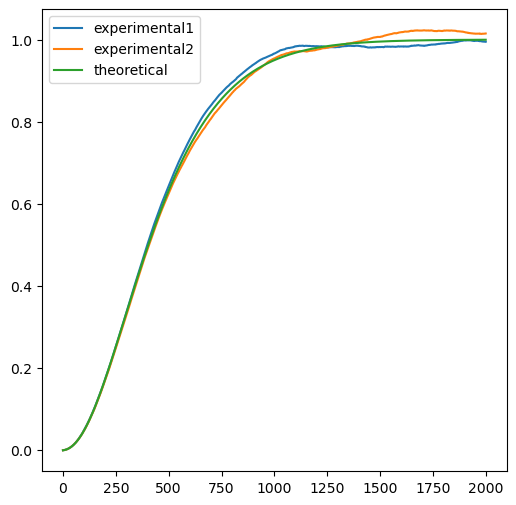

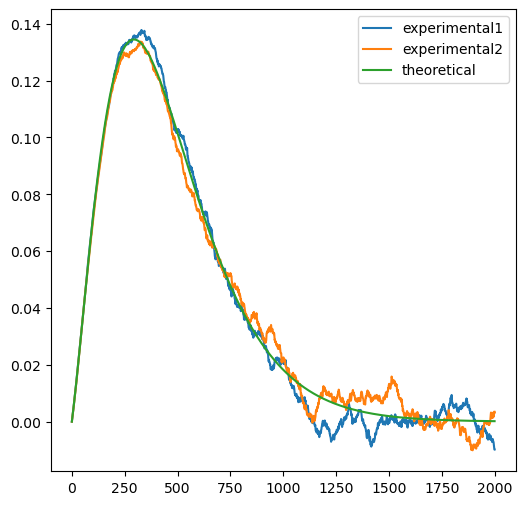

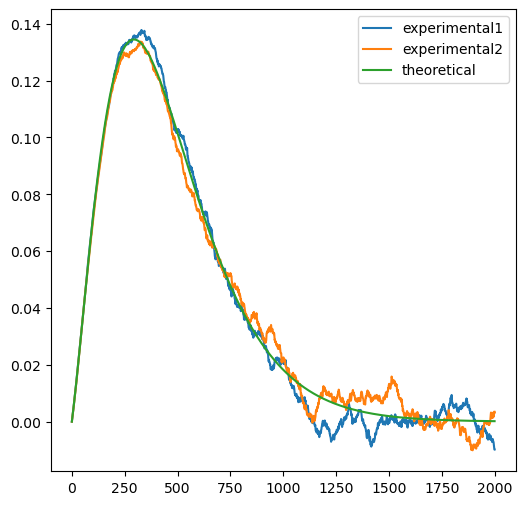

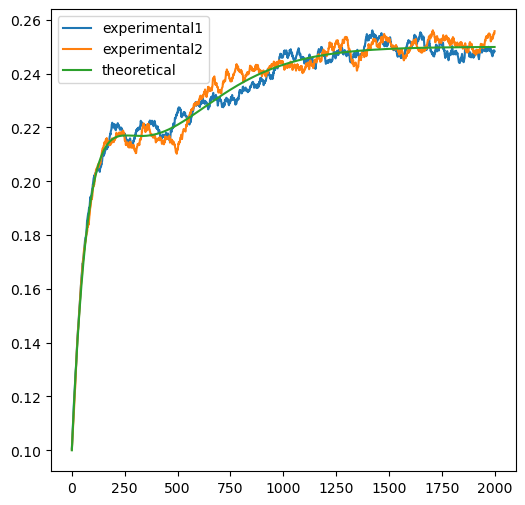

In [26]:
forward_covariances(jnp.array([0,0]), random.PRNGKey(7))

### rest

In [27]:
l_HSM = lambda t : jnp.sqrt( Sigma_xx(t)/(Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2) )

L_Cholesky = lambda t : jnp.array([ [jnp.sqrt(Sigma_xx(t)) , jnp.zeros( t.shape ) ] , [ Sigma_xv(t)/jnp.sqrt(Sigma_xx(t)) , jnp.sqrt( (Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2)/Sigma_xx(t) ) ]]).transpose((2,0,1))



In [28]:
# test 
batch = jnp.ones((batch_size,2,1))
t_batch = jnp.ones((batch_size,))

print(mu_global_HSM(t_batch, batch).shape)

print(L_Cholesky(t_batch).shape)

ee (512, 1)
(512, 2)
(512, 2)
(512, 2, 2)
(512, 2, 2)


In [29]:
L_Cholesky(jnp.array([10]))

Array([[[nan,  0.],
        [nan, nan]]], dtype=float32)

In [30]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """ 
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """ 
     
    magic_number = 1000 # NOTE custom magic number addapted for embed_dimension = 128 
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :
    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))
    ###

    return(embedding)


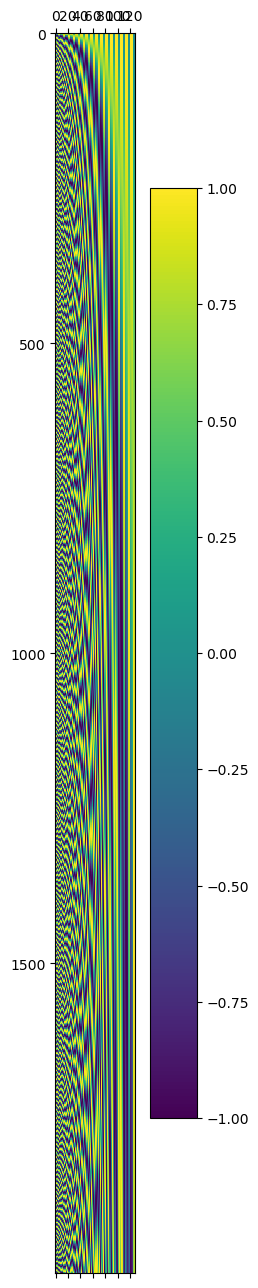

In [31]:
# test 
embedded = PositionalEncoding(jnp.arange(0,2000))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [32]:
class batch_MLP_bloc(nn.Module):                    # create a Flax Module dataclass
  out_dims: int

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dims)(x)       # shape inference
    return x


In [33]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 4)

def generateParameters(key):

    key, key1, key2, key3, key4 = random.split(key,5)

    # useless to put batch_size instead of '1'
    typical_batch = jnp.empty((batch_size, 2,1))
    typical_time_batch = jnp.empty((batch_size,intermediate_embeding_time_dimension))
    typical_embedded_batch = jnp.empty((batch_size, 3*intermediate_features_embedding))
    
    params_times = batch_MLP_embedding_layers.init(key1, typical_time_batch)
    params_positions = batch_MLP_embedding_layers.init(key2, typical_batch)
    params_velocities =  batch_MLP_embedding_layers.init(key3, typical_batch)
    params_global = batch_MLP_final_layers.init(key4, typical_embedded_batch)
    

    parameters = { 'params_times' : params_times,
                'params_positions' : params_positions,
                'params_velocities' : params_velocities,
                'params_global' : params_global }
    
    return(key,parameters)

In [34]:
# batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
# batch_MLP_final_layers = batch_MLP_bloc(out_dims= 4)

@jax.jit
def epsilon_model(parameters,batch_positions, batch_velocities, time_indices) :

    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    - time_indices : shape (batch_size,) should be integers (float of int)
    output :
    - shape (batch_size,2,dimension)
    """
    time_embedding = PositionalEncoding(time_indices)
    params_times = parameters['params_times']
    params_positions = parameters['params_positions']
    params_velocities = parameters['params_velocities']
    params_global = parameters['params_global']

    time_embedding = batch_MLP_embedding_layers.apply( params_times, time_embedding)
    position_embedding = batch_MLP_embedding_layers.apply( params_positions, batch_positions)
    velocity_embedding = batch_MLP_embedding_layers.apply( params_velocities, batch_velocities)
    
    global_embedding = jnp.concatenate( (time_embedding, position_embedding, velocity_embedding) , axis = 1)

    result = batch_MLP_final_layers.apply( params_global, global_embedding )[:,:,None]
    result = result.reshape(batch_size,2,2)

    return(result)

In [35]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
batch_velocities = random.normal(key, (batch_size,2,1) )
result = epsilon_model(parameters, batch, batch_velocities, times )
print(result.shape)

(512, 2, 2)


In [36]:


@jax.jit
def batch_loss(parameters, batch_positions, key) :
    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch_positions : positions batch shape (batch_size, 2, 1)
    """
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 1, maxval= num_timesteps)
    real_time_batch = timeIndeces2RealTime(time_indices )

    epsilon = random.normal(key3, shape = (batch_size,dimension, 2)) 

    batch_global = mu_global_HSM(real_time_batch, batch_positions) + (L_Cholesky(real_time_batch)[:,None,:,:]@epsilon[...,None])[...,0].transpose( (0,2,1) ) # shape (batch_size, 2,dim)
    batch_positions = batch_global[:,0,:]
    batch_velocities = batch_global[:,1,:]

    loss = jnp.mean(( epsilon.transpose((0,2,1)) - epsilon_model(parameters,batch_positions, batch_velocities, time_indices).squeeze()  )**2 )
    return(loss)
    

In [37]:
# test 
real_time_batch = jnp.ones((batch_size,))

epsilon = random.normal(key, shape = (batch_size, 2, dimension))

batch_global = L_Cholesky(real_time_batch)@epsilon
print(batch_size)
print(L_Cholesky(real_time_batch).shape)
print(epsilon.shape)
print(batch_global.shape)

512
(512, 2, 2)
(512, 2, 2)
(512, 2, 2)


In [38]:
a = "eztaeztr.dsgqsd"
a.replace(".","-")

'eztaeztr-dsgqsd'

In [39]:
savingFileName = "second_order_parameters_v3" + ("_beta" + str(beta) + "_M" + str(M) + "_nu" + str(nu) + "_Gamma" + str(Gamma)).replace(".","-") +".npy"
def train_or_retrieve_model(key, savingFileName = savingFileName ) :

    if os.path.isfile(savingFileName) :
        with open(savingFileName, 'rb') as file:
            parameters = pickle.load(file)
    else :
        key, parameters = generateParameters(key)

        learning_rate = 0.002
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(parameters)

        loss_cache = []
        i = 0
        while i < num_training_iterations :

            for batch in train_dataloader :
                batch = batch[0]

                key = random.split(key, 1)[0]
                value, grads = jax.value_and_grad(batch_loss)(parameters, batch, key)
                loss_cache.append(value)
                if i%500 == 0 :
                    print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
                    loss_cache = [] 
                updates, opt_state = optimizer.update(grads, opt_state)
                parameters = optax.apply_updates(parameters, updates)
                i+=1

        with open(savingFileName, 'wb') as file:
            pickle.dump(parameters, file)
    return(parameters)

In [40]:
parameters = train_or_retrieve_model(key)

ee (512, 1)
(512, 2)
(512, 2)
step : 0    -   loss : 1.0012102
step : 500    -   loss : 0.10291951
step : 1000    -   loss : 0.08876903
step : 1500    -   loss : 0.08786647
step : 2000    -   loss : 0.086829156
step : 2500    -   loss : 0.085766554
step : 3000    -   loss : 0.08548739
step : 3500    -   loss : 0.0857675
step : 4000    -   loss : 0.08594324
step : 4500    -   loss : 0.08563794
step : 5000    -   loss : 0.08412488
step : 5500    -   loss : 0.08496518
step : 6000    -   loss : 0.08507364
step : 6500    -   loss : 0.08402301
step : 7000    -   loss : 0.08409691
step : 7500    -   loss : 0.083834
step : 8000    -   loss : 0.08426275
step : 8500    -   loss : 0.08380089
step : 9000    -   loss : 0.083362974
step : 9500    -   loss : 0.08364856
step : 10000    -   loss : 0.08368137
step : 10500    -   loss : 0.08393872
step : 11000    -   loss : 0.0836008
step : 11500    -   loss : 0.08451198
step : 12000    -   loss : 0.08341653
step : 12500    -   loss : 0.08377855
step : 1

In [41]:
def score(parameters,batch_positions, batch_velocities, time_indices) :
    """ 
    input :
    - TODO write
    output :
    - shape (batch_size,2,dim)
    """
    real_time_batch = timeIndeces2RealTime(time_indices )
    return( -l_HSM(real_time_batch)[:,None,None]*epsilon_model(parameters,batch_positions, batch_velocities, time_indices) )

In [42]:
# test 
batch_positions = jnp.zeros((batch_size,2,1))
batch_velocities = jnp.zeros((batch_size,2,1))
time_indices = jnp.ones((batch_size,))

sco = score(parameters,batch_positions, batch_velocities, time_indices)
print(sco.shape)

(512, 2, 2)


[ 4.42971230e+01  4.08219833e+01  3.72494087e+01  3.34383049e+01
  2.96651344e+01  2.63968105e+01  2.11479340e+01  1.47778635e+01
  6.99675941e+00  5.76869166e-03 -5.14901829e+00 -1.16370230e+01
 -1.73917084e+01 -2.58587799e+01 -3.23580933e+01 -3.65656967e+01
 -4.01020622e+01 -4.42042046e+01 -4.77457008e+01 -5.09734192e+01
  4.61820450e+01  4.23248558e+01  3.86395416e+01  3.49211502e+01
  3.08974380e+01  2.73451385e+01  2.20113106e+01  1.53814154e+01
  7.22518969e+00 -4.34710383e-01 -5.97940111e+00 -1.29293594e+01
 -1.91938877e+01 -2.77677193e+01 -3.37006454e+01 -3.73850098e+01
 -4.13898277e+01 -4.55732956e+01 -4.91107178e+01 -5.21043892e+01
  4.81557770e+01  4.42441330e+01  4.03768120e+01  3.64164581e+01
  3.24280968e+01  2.73253937e+01  2.24417400e+01  1.58411007e+01
  7.76629734e+00 -2.74259835e-01 -7.30324745e+00 -1.42499228e+01
 -2.13882351e+01 -2.91536770e+01 -3.47710915e+01 -3.86922951e+01
 -4.30843086e+01 -4.70410042e+01 -5.03915710e+01 -5.32650146e+01
  5.02143517e+01  4.62636

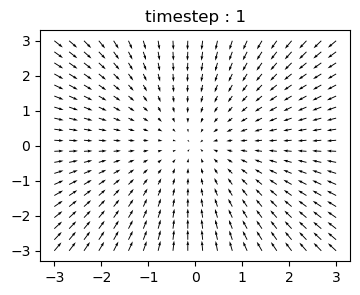

[ 25.956575   23.303413   20.212074   17.24124    14.742123   12.601744
  10.306349    7.861869    4.756935    1.5884668  -1.5569112  -5.1964436
  -7.521427  -11.126157  -14.002307  -16.178753  -18.327854  -20.93177
 -23.671268  -26.398266   26.313015   23.747143   21.07241    17.895157
  14.768365   12.743022   10.41461     8.009041    4.8510227   1.56768
  -1.5837692  -5.207506   -7.7439938 -11.518514  -14.147943  -16.215393
 -18.695593  -21.491632  -24.270159  -26.95602    26.761448   24.163523
  21.58201    18.734509   15.539209   12.445815   10.366192    8.050814
   4.993749    1.6110424  -1.61211    -5.1780148  -8.152298  -11.735735
 -14.151325  -16.456295  -19.239435  -22.155773  -24.840265  -27.545774
  27.46084    24.665918   21.95867    19.264643   16.282217   13.031428
  10.38477     8.059408    5.1438413   1.6969879  -1.6777183  -5.1071167
  -8.880401  -11.811102  -14.148375  -16.986929  -20.035313  -22.742468
 -25.44763   -28.222744   28.308428   25.433277   22.498318   19

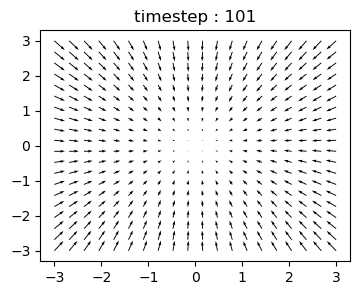

[ 18.138073    16.386717    14.316849    12.08132     10.33332
   8.603257     6.7781963    4.7820587    2.339129     0.22341627
  -1.3743266   -3.218823    -4.4987965   -6.069519    -7.862768
  -9.436729   -10.968512   -12.781181   -14.664703   -16.41176
  18.210972    16.337362    14.5802965   12.405594    10.293123
   8.648325     6.7955723    4.8682413    2.3775697    0.28068608
  -1.3117162   -3.147042    -4.3987546   -6.200189    -7.8508234
  -9.332618   -11.062132   -12.956305   -14.709629   -16.605602
  18.321148    16.44156     14.566487    12.700302    10.470563
   8.3779       6.6762576    4.8270874    2.4437687    0.37041977
  -1.258379    -3.0462663   -4.3800883   -6.212055    -7.709749
  -9.356531   -11.204713   -13.026233   -14.845684   -17.01465
  18.485376    16.492994    14.61696     12.666898    10.773303
   8.575813     6.6934257    4.7827682    2.4631777    0.4716841
  -1.1816577   -2.9105806   -4.40879     -6.116925    -7.5819626
  -9.483416   -11.313807   -13.133

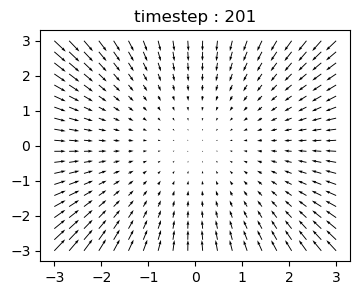

[ 13.646204    12.193789    10.739274     9.0204735    7.4571376
   5.977361     4.669322     3.3535435    2.0310292    0.76874644
  -0.6009137   -2.1087866   -3.1689665   -4.4475737   -5.7009363
  -6.790556    -7.876356    -9.181518   -10.584682   -12.076004
  13.452068    11.984716    10.568969     9.080881     7.3067684
   5.903433     4.62924      3.3126266    2.0236306    0.7605883
  -0.5877349   -2.1116855   -3.092368    -4.451644    -5.679464
  -6.703845    -7.902963    -9.322833   -10.649433   -12.160536
  13.259363    11.801867    10.344771     8.883764     7.310201
   5.6731415    4.5196404    3.2698834    2.0298245    0.75823313
  -0.561577    -2.0432472   -3.0729332   -4.4171205   -5.582004
  -6.736764    -8.042681    -9.357908   -10.694841   -12.208653
  13.175523    11.635055    10.144345     8.622661     7.170257
   5.7542458    4.491921     3.2456923    2.0133986    0.76634157
  -0.56396973  -1.9312297   -3.1084256   -4.3650813   -5.5261273
  -6.8022656   -8.065273    -

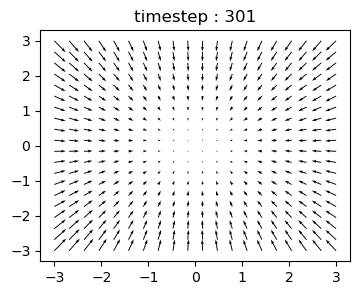

[ 11.111959     9.853043     8.6088705    7.2638836    6.1461773
   5.0523       3.9634507    2.9689968    1.9011465    0.76990426
  -0.36872083  -1.5913901   -2.5803912   -3.6328168   -4.6959534
  -5.710331    -6.7151327   -7.829267    -8.946408   -10.102727
  10.875093     9.652649     8.47473      7.2168136    6.068099
   5.0445724    3.9460008    2.9240696    1.8389077    0.73114103
  -0.40588605  -1.5948077   -2.516565    -3.6125705   -4.693907
  -5.651899    -6.7325053   -7.848632    -8.915531   -10.089544
  10.691501     9.483329     8.29164      7.108021     6.0143976
   4.840752     3.8662062    2.8579152    1.783109     0.68119955
  -0.4334881   -1.5941601   -2.5114608   -3.534165    -4.5938554
  -5.652919    -6.754991    -7.803291    -8.923848   -10.124189
  10.606617     9.352949     8.126706     6.97883      5.9340563
   4.8966217    3.8144584    2.788255     1.7083275    0.6267597
  -0.45567364  -1.4849254   -2.464932    -3.4673073   -4.5254307
  -5.6646833   -6.709953   

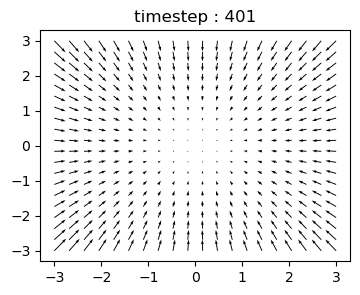

[ 8.55468     7.6048737   6.704004    5.8596206   4.9643106   4.07122
  3.1289434   2.227402    1.254733    0.42151597 -0.36483237 -1.2625824
 -2.0856314  -2.9317694  -3.6794424  -4.5145082  -5.371071   -6.299532
 -7.3245263  -8.275084    8.4567585   7.4921846   6.636919    5.731398
  4.8604255   4.0375013   3.1007957   2.1915848   1.2268865   0.4005628
 -0.3934716  -1.3353319  -2.0820045  -2.8939607  -3.697045   -4.419633
 -5.3219376  -6.295012   -7.238505   -8.191526    8.351378    7.392148
  6.5536647   5.7066855   4.8133993   3.9022167   3.0499408   2.1375163
  1.2228076   0.3965016  -0.40883332 -1.3836063  -2.0901816  -2.8455477
 -3.6435802  -4.436009   -5.3292255  -6.248923   -7.1776166  -8.119114
  8.290081    7.348829    6.5086308   5.6568766   4.8036513   3.9791892
  3.0629377   2.114103    1.2182137   0.39835468 -0.40835837 -1.2952231
 -2.1130614  -2.8610592  -3.634784   -4.483033   -5.2613177  -6.2122087
 -7.157189   -8.132518    8.288116    7.318386    6.470066    5.6025124

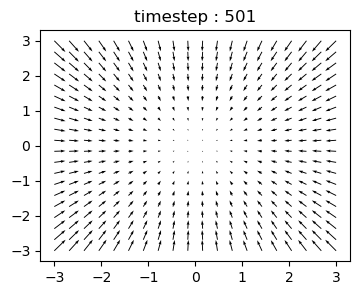

[ 7.4168553   6.6592484   5.853723    5.108228    4.292545    3.4761128
  2.6220586   1.9291741   1.1462425   0.36822575 -0.36193356 -1.1979938
 -1.9403192  -2.6481407  -3.277836   -3.9465299  -4.631482   -5.4259925
 -6.258021   -7.072461    7.373797    6.6067944   5.839747    4.9990716
  4.2352796   3.475856    2.6428947   1.9381112   1.1641623   0.38136664
 -0.3551249  -1.209378   -1.8884317  -2.6006885  -3.3006725  -3.9362915
 -4.6779876  -5.486104   -6.2257133  -7.020672    7.3412833   6.571057
  5.7972546   4.9924874   4.1533084   3.3341713   2.625124    1.9228572
  1.1881802   0.40672764 -0.33933324 -1.206344   -1.8702672  -2.531729
 -3.2651951  -3.9941452  -4.7511954  -5.4781666  -6.2182655  -6.9745345
  7.293601    6.540837    5.7578397   4.964757    4.172249    3.4084806
  2.6588182   1.9059788   1.1827424   0.4205713  -0.32314286 -1.1364951
 -1.8731483  -2.4984968  -3.2513175  -4.050124   -4.7624984  -5.4873433
 -6.200906   -6.942587    7.287952    6.5281854   5.7689643   4.9

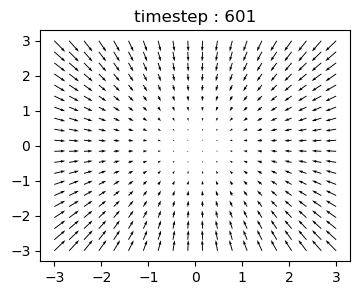

[ 6.999185    6.2562766   5.472583    4.7635374   3.991391    3.2413642
  2.5147135   1.8874328   1.14812     0.39628989 -0.3168671  -1.1065775
 -1.8344513  -2.5043786  -3.084949   -3.7251318  -4.377909   -5.1362844
 -5.927568   -6.65225     6.954596    6.2080483   5.4665394   4.652156
  3.940165    3.274688    2.5449338   1.8826525   1.1582526   0.40791723
 -0.31244785 -1.1161577  -1.7705166  -2.4603183  -3.104745   -3.7143924
 -4.438026   -5.19519    -5.914426   -6.638456    6.925862    6.1775317
  5.4483566   4.690174    3.9034069   3.191576    2.5315592   1.857818
  1.1508873   0.40915295 -0.3046271  -1.0936687  -1.742721   -2.3979552
 -3.0630515  -3.7686527  -4.50249    -5.2074943  -5.906988   -6.6305737
  6.8989673   6.2003837   5.46542     4.6952276   3.9346666   3.2722325
  2.5639694   1.8384607   1.1406698   0.40264574 -0.32265785 -1.0387353
 -1.7495267  -2.3635035  -3.0464702  -3.8162055  -4.5082836  -5.2175307
 -5.9019847  -6.5490203   6.925424    6.193066    5.467562    4.6

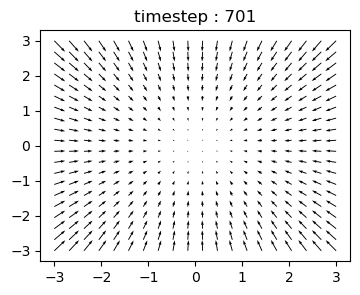

[ 6.673764    5.9495397   5.183336    4.49214     3.7820296   3.1359499
  2.4416814   1.8239475   1.1154118   0.3839421  -0.31058824 -1.0328578
 -1.7424144  -2.4040768  -2.970452   -3.5812895  -4.193138   -4.9216065
 -5.69494    -6.4052877   6.6348352   5.903865    5.190432    4.4128036
  3.7866092   3.175001    2.4686275   1.8172914   1.1056372   0.37679213
 -0.29952136 -1.0247092  -1.6819404  -2.3607178  -2.9872935  -3.570059
 -4.252358   -4.9850473  -5.68246    -6.394604    6.626834    5.9230094
  5.208792    4.464535    3.763236    3.0930698   2.4550622   1.7924396
  1.0962214   0.3682744  -0.29842696 -1.0208765  -1.6546569  -2.2966182
 -2.9444594  -3.6190162  -4.31469    -4.9949703  -5.681057   -6.3732114
  6.615948    5.9426737   5.2237725   4.477571    3.7998188   3.1586542
  2.4847713   1.7733709   1.0859821   0.35876513 -0.30223328 -0.96833324
 -1.6756545  -2.2663429  -2.9327438  -3.6539285  -4.313653   -5.0039997
 -5.6600695  -6.286505    6.6292624   5.9241595   5.206442    4

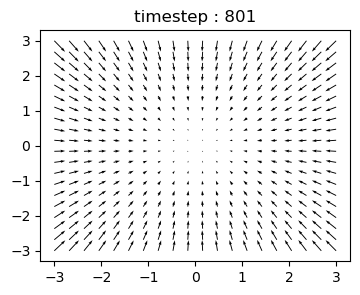

[ 6.3868575   5.673453    4.931537    4.314932    3.6834996   3.0445237
  2.3699126   1.7709497   1.0742437   0.3600326  -0.27557874 -0.9677433
 -1.666297   -2.3179166  -2.8745322  -3.4791093  -4.0817704  -4.751127
 -5.499006   -6.200285    6.363089    5.66602     4.9799128   4.268642
  3.6880672   3.082891    2.3897147   1.7621136   1.0627862   0.35351992
 -0.27882463 -0.96987283 -1.6072425  -2.2752094  -2.8890345  -3.4680693
 -4.13383    -4.81222    -5.4873123  -6.190831    6.384134    5.683235
  4.987214    4.3365455   3.6551676   3.0015466   2.373092    1.7365618
  1.0531112   0.35931474 -0.27816254 -0.9862314  -1.5942899  -2.2159142
 -2.8499033  -3.5139117  -4.1861606  -4.819422   -5.4984126  -6.1513076
  6.3751426   5.703062    5.0096803   4.3437147   3.6786757   3.0536537
  2.3942513   1.7145399   1.042796    0.36863717 -0.28448343 -0.9316844
 -1.6166815  -2.1851413  -2.845381   -3.5564814  -4.1832604  -4.835344
 -5.471717   -6.0876155   6.391177    5.6876535   5.005104    4.357

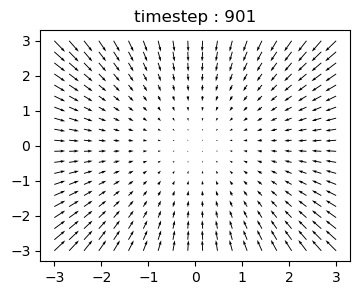

[ 6.198672    5.5159683   4.796307    4.2332993   3.6186008   2.9844143
  2.3170044   1.7222242   1.040013    0.3630564  -0.25868475 -0.9261553
 -1.6220587  -2.2673023  -2.812953   -3.4132288  -4.011088   -4.6739764
 -5.370008   -6.066431    6.2027073   5.5127087   4.8606977   4.184696
  3.6232328   3.022437    2.334499    1.7134509   1.0269729   0.36198056
 -0.26581648 -0.9429324  -1.5710939  -2.2266295  -2.8252354  -3.402267
 -4.0610714  -4.729798   -5.3670692  -6.0569124   6.2212768   5.528021
  4.8845906   4.245109    3.5814886   2.9371514   2.3175695   1.6879048
  1.028401    0.36676162 -0.2669003  -0.9631062  -1.559577   -2.1728404
 -2.794763   -3.4495811  -4.1158857  -4.7223263  -5.379482   -6.0081196
  6.211192    5.5396175   4.909178    4.2491407   3.6001315   2.9852514
  2.328317    1.6567526   1.0317911   0.37703922 -0.27340186 -0.9075301
 -1.5836169  -2.1409783  -2.7911432  -3.4919662  -4.1167946  -4.734836
 -5.3586054  -5.9665112   6.2269044   5.5424433   4.9018655   4.260

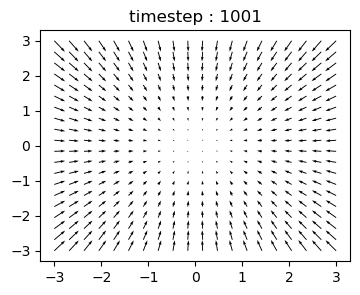

[ 6.1272726   5.4516892   4.762396    4.201673    3.5883148   2.957552
  2.295006    1.7031032   1.0248687   0.3639371  -0.2547972  -0.9131422
 -1.5989261  -2.2439744  -2.7853212  -3.3835566  -3.978212   -4.638117
 -5.3084064  -5.996977    6.131118    5.4449587   4.8233256   4.1507363
  3.5929244   2.9953902   2.3105557   1.6943722   1.0160129   0.36282113
 -0.261458   -0.9283121  -1.5539943  -2.2075605  -2.79473    -3.3726487
 -4.0281754  -4.6938457  -5.312271   -5.987636    6.1489277   5.4628386
  4.846635    4.210714    3.5482314   2.9056957   2.2891557   1.6686724
  1.0225164   0.36765796 -0.26369324 -0.94879407 -1.5421156  -2.1504445
 -2.767278   -3.4164124  -4.086767   -4.688984   -5.327856   -5.9518166
  6.1388144   5.4916806   4.868422    4.2115583   3.566155    2.9550955
  2.2998102   1.6334151   1.021779    0.37694007 -0.27016273 -0.8938061
 -1.5677576  -2.1183007  -2.7637305  -3.458481   -4.0857882  -4.6991615
 -5.3115788  -5.915084    6.1505485   5.4972897   4.8598113   4.2

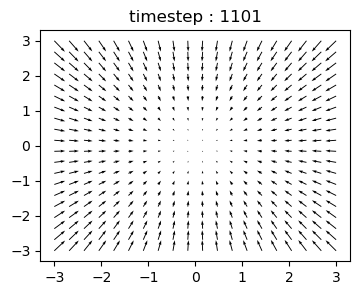

[ 6.0398173   5.368588    4.7169933   4.1614585   3.5465152   2.9254806
  2.2658508   1.6758715   1.0061074   0.36329353 -0.24944228 -0.90481436
 -1.573831   -2.2187393  -2.7543824  -3.3507257  -3.9414647  -4.599469
 -5.2615247  -5.918088    6.0437384   5.375264    4.774001    4.103766
  3.544398    2.9598384   2.2803268   1.6670043   1.0097888   0.3609719
 -0.25482363 -0.91517454 -1.5341756  -2.1869657  -2.7648923  -3.3378472
 -3.9915102  -4.6539783  -5.2618456  -5.913035    6.060946    5.4099708
  4.795754    4.160936    3.5037525   2.8662283   2.2516916   1.6360725
  1.0156399   0.36409757 -0.2586546  -0.930045   -1.5221479  -2.1283941
 -2.7375305  -3.3839588  -4.0533752  -4.653636   -5.2730207  -5.8882346
  6.0485754   5.4335275   4.814524    4.1598105   3.517882    2.9172273
  2.262316    1.61528     1.0079143   0.3654487  -0.2670081  -0.8758482
 -1.5497824  -2.0936215  -2.7359385  -3.4257677  -4.045965   -4.65942
 -5.2500777  -5.8502545   6.0587807   5.4387956   4.803598    4.171

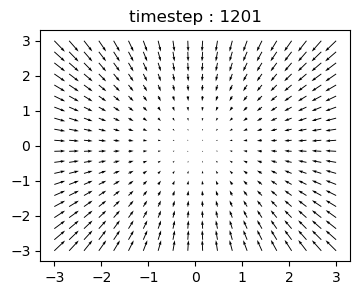

[ 5.971852    5.325163    4.6822634   4.130553    3.5165794   2.90135
  2.2442553   1.6556201   1.0020939   0.36175716 -0.24525715 -0.89780873
 -1.5581616  -2.1994624  -2.7299247  -3.3277707  -3.913941   -4.5707593
 -5.226937   -5.856901    5.975652    5.337935    4.7391477   4.0703573
  3.508959    2.9293633   2.2550254   1.6463541   1.005358    0.35840008
 -0.2499578  -0.9079824  -1.5185925  -2.171029   -2.7414224  -3.3128
 -3.9668322  -4.6246405  -5.227257   -5.8600655   5.9927626   5.37263
  4.7596726   4.124416    3.4710112   2.8359547   2.222742    1.6200329
  1.0062912   0.36096406 -0.25603542 -0.9157962  -1.5074718  -2.1114113
 -2.7140794  -3.3595655  -4.026128   -4.628447   -5.242556   -5.8418417
  5.991998    5.3913274   4.775624    4.1223216   3.482747    2.8884745
  2.2352247   1.6040335   0.99781305  0.35676658 -0.26943177 -0.86604303
 -1.5357709  -2.0742576  -2.7141373  -3.402371   -4.015874   -4.630458
 -5.219894   -5.802546    6.0152054   5.3965564   4.763915    4.13375

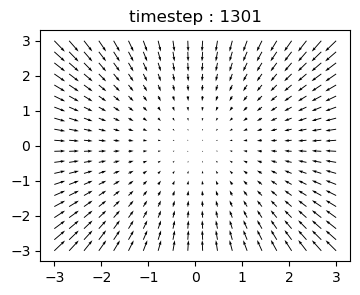

[ 5.935517    5.3024035   4.6604114   4.1103163   3.4967868   2.8842735
  2.2315977   1.643871    0.9992027   0.36034673 -0.24608587 -0.89464974
 -1.5499434  -2.1900384  -2.7173102  -3.3146195  -3.8998106  -4.5543084
 -5.20845    -5.8336754   5.939222    5.314392    4.717216    4.0493693
  3.4875512   2.9103496   2.2391667   1.6344928   1.0022837   0.35644287
 -0.25065082 -0.9048088  -1.5104301  -2.162312   -2.7292192  -3.299618
 -3.9548845  -4.609097   -5.207661   -5.832615    5.96253     5.3489947
  4.736917    4.1022644   3.4516094   2.8192933   2.2069454   1.6133008
  1.0003742   0.3569196  -0.25712556 -0.9082723  -1.4998085  -2.1022716
 -2.7018914  -3.3466346  -4.0116587  -4.6129565  -5.2245774  -5.814064
  5.966947    5.365684    4.7518353   4.099468    3.4614432   2.8712728
  2.2275229   1.5973104   0.9918567   0.35176608 -0.2727284  -0.862477
 -1.5296484  -2.0628831  -2.7027702  -3.3896685  -4.002306   -4.6149464
 -5.2014356  -5.7743926   5.988564    5.370788    4.7397647   4.1

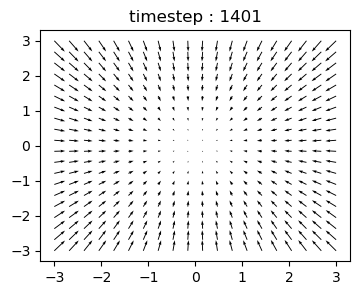

[ 5.9235454   5.284983    4.6435766   4.096293    3.482137    2.8709269
  2.2241359   1.636995    0.99659693  0.3581248  -0.24781696 -0.89558387
 -1.5478168  -2.1873116  -2.7148654  -3.3081207  -3.8927722  -4.5463285
 -5.198637   -5.8309197   5.9271817   5.296252    4.7003293   4.033093
  3.4729102   2.8965535   2.232714    1.6292545   0.99947655  0.35484427
 -0.25216904 -0.90573364 -1.5083395  -2.1591604  -2.726589   -3.2964861
 -3.9466405  -4.598693   -5.1987     -5.823084    5.9440885   5.3306193
  4.719149    4.087113    3.439493    2.8059804   2.200588    1.609141
  0.99675834  0.35395277 -0.2581635  -0.9058349  -1.4978154  -2.09959
 -2.699313   -3.3438518  -4.007033   -4.6025486  -5.2144628  -5.7963142
  5.9480834   5.348264    4.735165    4.0834403   3.446651    2.859584
  2.2246108   1.5931677   0.9881342   0.3487236  -0.27433872 -0.86155313
 -1.5282037  -2.0578768  -2.7005875  -3.3857417  -3.9978197  -4.604559
 -5.1870522  -5.7574873   5.970212    5.3535466   4.723114    4.094

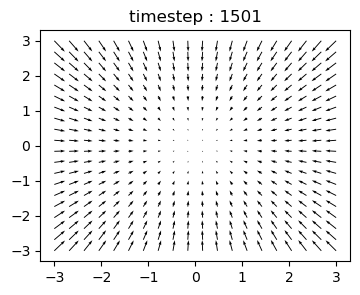

[ 5.9068985   5.272791    4.63176     4.0848637   3.4710665   2.8615704
  2.2176752   1.6313293   0.9951642   0.35713044 -0.24880406 -0.8952309
 -1.543962   -2.1828418  -2.709063   -3.3011642  -3.8854733  -4.53825
 -5.1894455  -5.8203487   5.9104595   5.283548    4.688478    4.0216317
  3.4618452   2.8857474   2.225336    1.6258503   0.9977679   0.35371786
 -0.25280648 -0.9051921  -1.5045073  -2.1548789  -2.7206085  -3.2904723
 -3.940099   -4.590315   -5.188887   -5.8129053   5.9304256   5.3178425
  4.706723    4.075278    3.4295533   2.795228    2.1932385   1.605724
  0.9936154   0.35165712 -0.25893146 -0.9021909  -1.4943247  -2.0954196
 -2.693342   -3.337857   -3.9999192  -4.594168   -5.2051024  -5.781455
  5.9349365   5.33475     4.7224445   4.0711026   3.4351506   2.8499265
  2.2209325   1.5897894   0.9849964   0.346447   -0.2761679  -0.85967785
 -1.5259635  -2.0521116  -2.6955745  -3.3795977  -3.9913185  -4.5962296
 -5.176576   -5.742345    5.9561954   5.3403354   4.710272    4.08

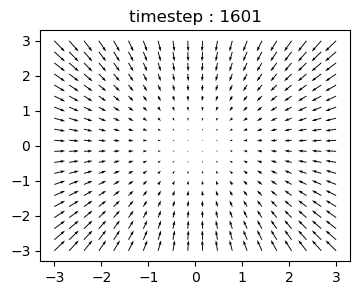

[ 5.9099026   5.271756    4.6309614   4.0846105   3.4710407   2.8612602
  2.217176    1.6315856   0.99475545  0.3568094  -0.24873078 -0.8954017
 -1.5447943  -2.1835644  -2.7104108  -3.3015742  -3.8856683  -4.538321
 -5.189267   -5.8230047   5.913443    5.282554    4.6876583   4.02106
  3.4618242   2.8860874   2.2264688   1.6257398   0.99739933  0.35367718
 -0.25290194 -0.90553087 -1.5053548  -2.1553454  -2.7219806  -3.291582
 -3.9394536  -4.5897236  -5.189335   -5.813123    5.930333    5.316788
  4.7059245   4.0752125   3.4297445   2.795601    2.1943793   1.6056213
  0.9937426   0.3520205  -0.2587454  -0.9030592  -1.4950368  -2.0959878
 -2.6947372  -3.3389494  -3.9999394  -4.593576   -5.20491    -5.781498
  5.933502    5.334424    4.722165    4.071079    3.4353201   2.8503158
  2.2210982   1.5896969   0.98512703  0.34678966 -0.27557182 -0.86007
 -1.5261282  -2.0527089  -2.6966028  -3.380378   -3.991872   -4.595589
 -5.175605   -5.742916    5.955597    5.3399024   4.710073    4.0823975


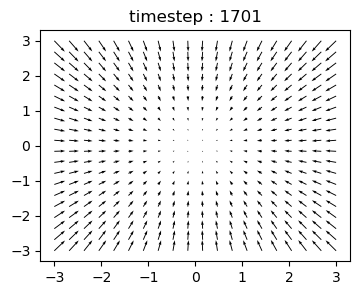

[ 5.9163327   5.2728844   4.6322393   4.0866494   3.4732223   2.862811
  2.2185166   1.6331632   0.99459434  0.3566217  -0.24862163 -0.89618325
 -1.5462692  -2.1849873  -2.712679   -3.3028579  -3.8868158  -4.5397525
 -5.190949   -5.8271356   5.919875    5.2837806   4.6889234   4.022479
  3.4640074   2.8885608   2.2291856   1.6262391   0.9973112   0.35373542
 -0.25294805 -0.906321   -1.5068381  -2.1564765  -2.72407    -3.2935772
 -3.9396517  -4.5908127  -5.1912675  -5.8149104   5.9367623   5.317967
  4.707268    4.0771904   3.4318228   2.7980952   2.1971164   1.6061248
  0.99441284  0.35275552 -0.258477   -0.9045615  -1.496458   -2.0973203
 -2.6968465  -3.3409338  -4.000059   -4.59415    -5.2060585  -5.7839565
  5.934425    5.3364706   4.724069    4.0731397   3.4374542   2.8525121
  2.2218783   1.5902183   0.98579913  0.34750253 -0.27469108 -0.86061573
 -1.526633   -2.054226   -2.6983755  -3.3820243  -3.9933755  -4.5961733
 -5.1760187  -5.745697    5.957461    5.3417897   4.7121058   4.

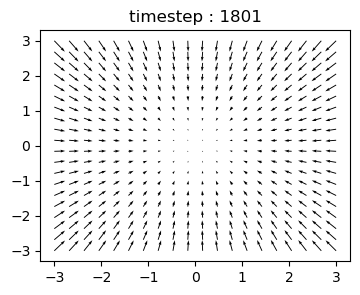

[ 5.8810015   5.261774    4.6212215   4.072914    3.4595757   2.8520043
  2.2100677   1.6243143   0.994149    0.35704324 -0.24881001 -0.89169157
 -1.5379293  -2.1761239  -2.6998222  -3.2932978  -3.877171   -4.528103
 -5.1790214  -5.801975    5.8845243   5.2722254   4.677897    4.0115485
  3.4502187   2.8743029   2.2145855   1.622137    0.99653804  0.3528348
 -0.2527181  -0.9013768  -1.4985043  -2.1489398  -2.711606   -3.2808673
 -3.9341595  -4.5823817  -5.1778474  -5.800184    5.9187117   5.306577
  4.695456    4.0637193   3.4186635   2.7838514   2.1843965   1.6020259
  0.9902961   0.34909838 -0.26013926 -0.8969697  -1.4886624  -2.089248
 -2.6843257  -3.3282175  -3.9899943  -4.586232   -5.1948776  -5.7725687
  5.9220767   5.3212223   4.7101645   4.0593047   3.4240415   2.8395045
  2.21582     1.5860604   0.9816839   0.34394988 -0.27825758 -0.85893387
 -1.5226024  -2.046523   -2.6873503  -3.3707626  -3.9820254  -4.5889187
 -5.1681423  -5.7266874   5.9422927   5.32724     4.697646    4.0

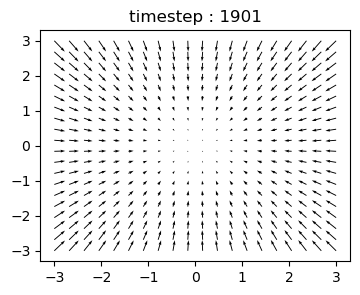

In [43]:
# test 
batch_velocities = jnp.zeros((batch_size, 2, 1))
# Batch_size must be superior to 400 for this test
for timestep in range(1,num_timesteps,100) :
    x,y = np.meshgrid(np.linspace(-3,3,20),np.linspace(-3,3,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters, batch, batch_velocities, time_indices)[:400]
    u,v = scores[:,0,0], scores[:,0,1]

    # print( scores[:,0,0])
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [44]:
# TEST 
# chercher le forward et les matrices de covariances pour un batch

In [45]:
@jax.jit
def deterministic_predictor(batch, i, step_size, parameters ) :

    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """

    batch_positions = batch[:,0,:] 
    batch_velocities = batch[:,1,:] 

    score_global = score(parameters, batch_positions, batch_velocities, time_indices[i+1])
    score_x = score_global[:,0,:,None]
    score_v = score_global[:,1,:,None]
    print("score_v",score_v.shape)
    print(score_x.shape)
    print("batch_positions" ,batch_positions.shape)
    print("batch_velocities",batch_velocities.shape)

    print("values of update", -( Gamma*batch_positions + 1.0/M*batch_velocities)*beta/2.*step_size[:,None,None] + \
                              jnp.sqrt(Gamma*beta*step_size[:,None,None])*0 + \
                              ( Gamma*batch_positions*0 + 2*Gamma*score_x )*beta*step_size[:,None,None] )

    

    batch_positions_updated = batch_positions + \
                              -( Gamma*batch_positions + 1.0/M*batch_velocities)*beta/2.*step_size[:,None,None] + \
                              jnp.sqrt(Gamma*beta*step_size[:,None,None])*0 + \
                              ( Gamma*batch_positions*0 + 2*Gamma*score_x )*beta*step_size[:,None,None]
    batch_velocities_updated = batch_velocities + \
                               (batch_positions - nu*batch_velocities)*beta/2.*step_size[:,None,None] + \
                               jnp.sqrt(M*nu*beta*step_size[:,None,None])*0 + \
                               ( nu*batch_velocities*0 + 2*M*nu*score_v )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(batch)

In [46]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_deterministic_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        batch = deterministic_predictor( batch, i, stepSize[i], parameters )
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

score_v (512, 2, 1)
(512, 2, 1)
batch_positions (512, 2, 1)
batch_velocities (512, 2, 1)
values of update Traced<ShapedArray(float32[512,2,1])>with<DynamicJaxprTrace(level=1/0)>


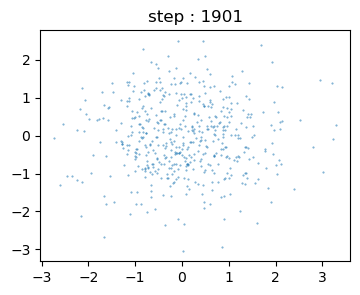

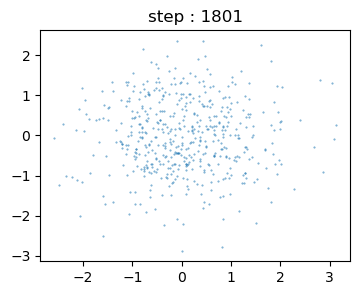

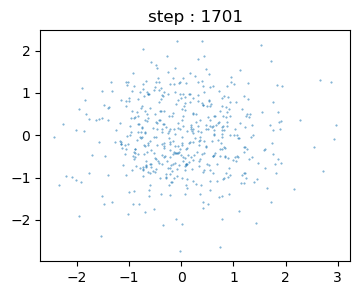

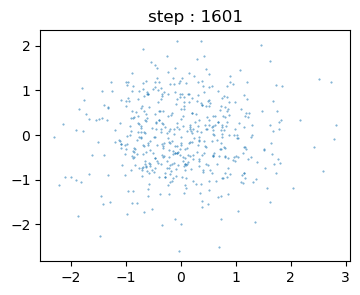

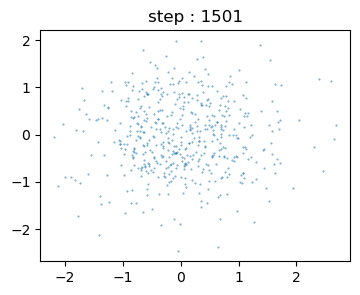

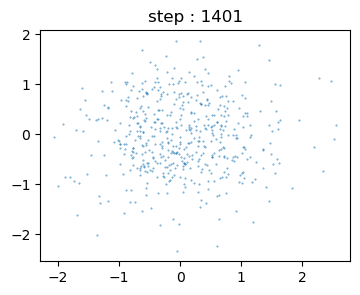

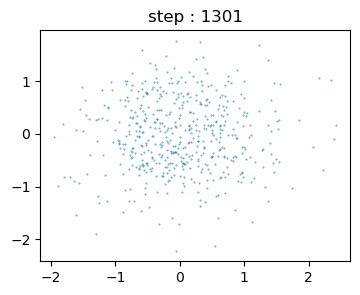

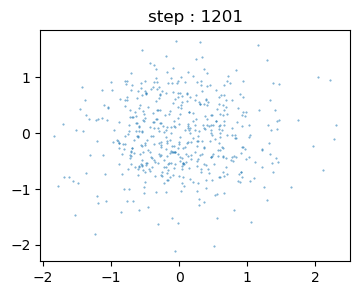

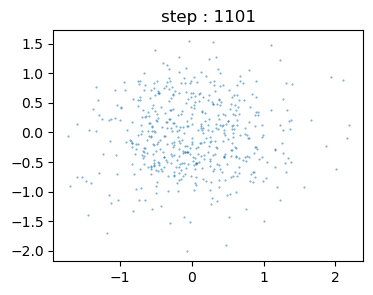

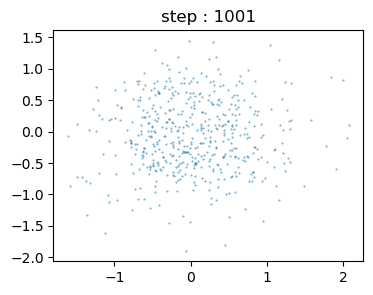

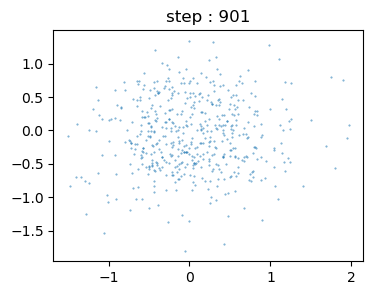

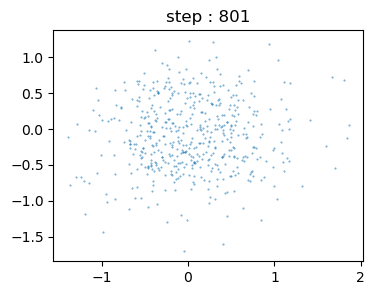

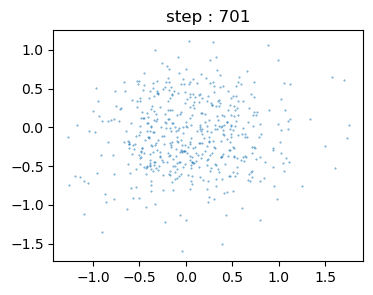

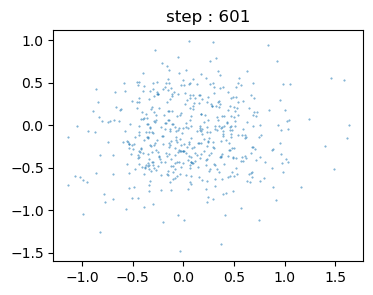

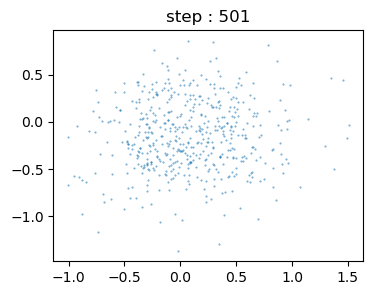

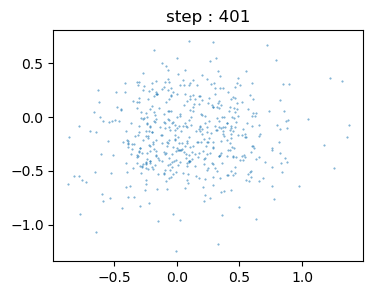

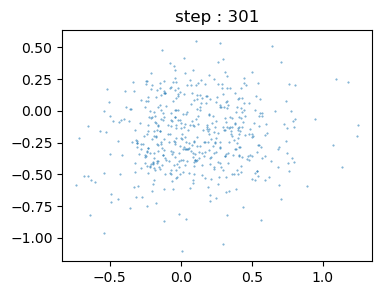

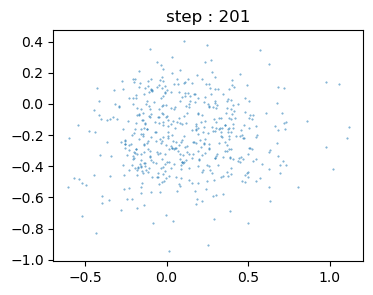

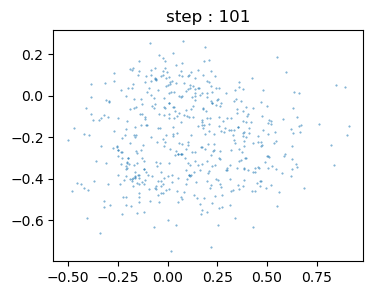

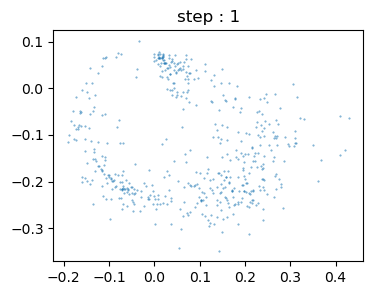

In [47]:
# with jax.disable_jit():
#     result = generate_deterministic_batch(key, parameters, time_indices = time_indices)

result = generate_deterministic_batch(key, parameters, time_indices = time_indices)


In [48]:
@jax.jit
def predictor(batch, i, step_size, parameters, key ) :
    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """
    key, subkey = random.split(key)
    
    batch_positions = batch[:,0,...] 
    batch_velocities = batch[:,1,...] 

    w = random.normal(subkey, shape = batch.shape)
    w_x = w[:,0,:,:]
    w_v = w[:,1,:,:]

    score_global = score(parameters, batch_positions, batch_velocities, time_indices[i+1])
    score_x = score_global[:,0,:,None]
    score_v = score_global[:,1,:,None]
    

    batch_positions_updated = batch_positions + \
                              -( Gamma*batch_positions + 1.0/M*batch_velocities)*beta/2.*step_size[:,None,None] + \
                              jnp.sqrt(Gamma*beta*step_size[:,None,None])*w_x + \
                              ( Gamma*batch_positions + Gamma*score_x )*beta*step_size[:,None,None]
    batch_velocities_updated = batch_velocities + \
                               (batch_positions - nu*batch_velocities)*beta/2.*step_size[:,None,None] + \
                               jnp.sqrt(M*nu*beta*step_size[:,None,None])*w_v + \
                               ( nu*batch_velocities + M*nu*score_v )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(key, batch)

In [49]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        key, batch = predictor( batch, i, stepSize[i], parameters, key)
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

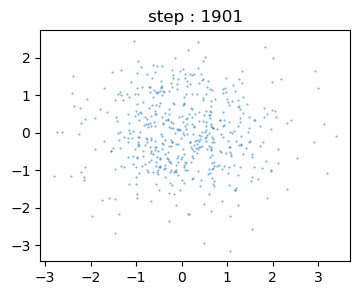

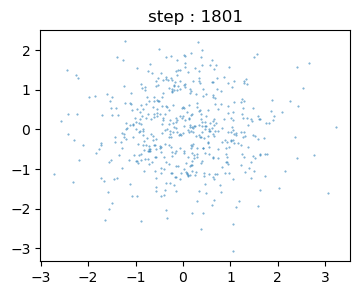

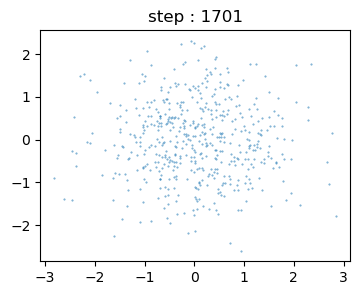

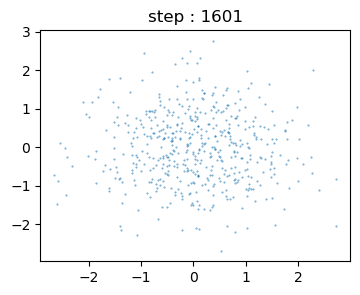

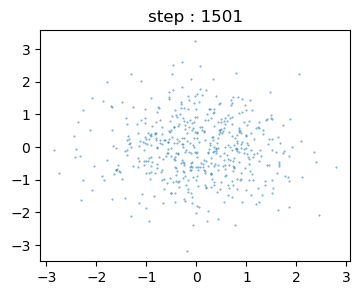

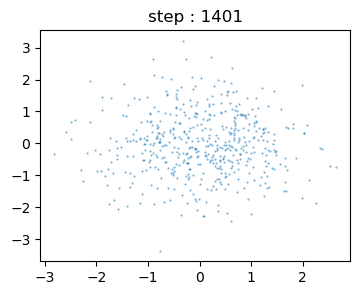

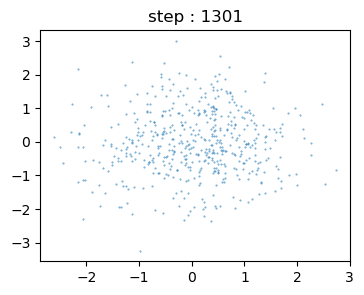

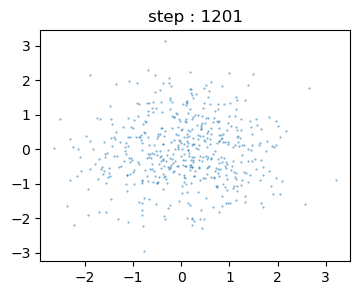

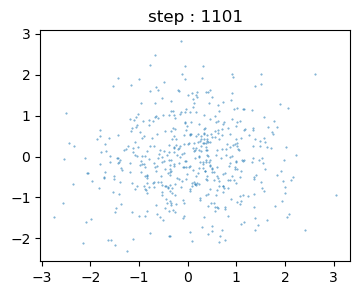

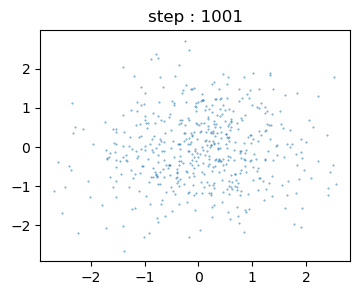

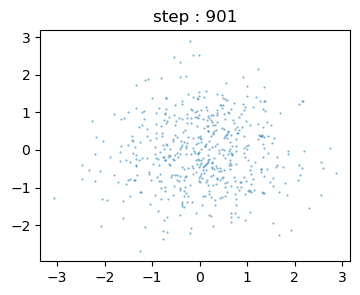

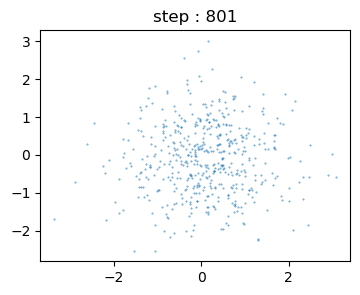

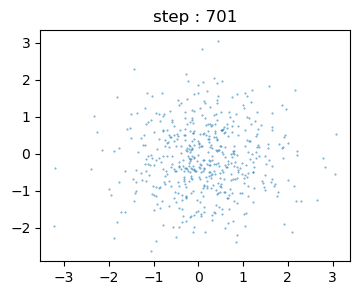

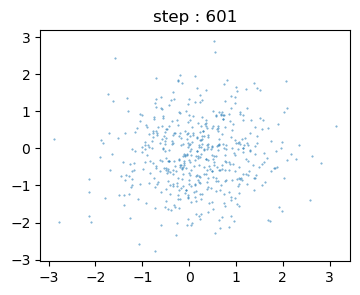

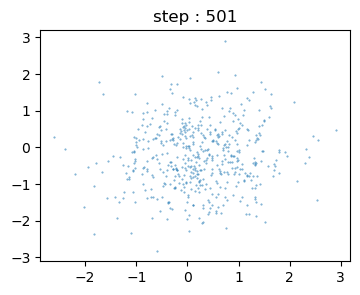

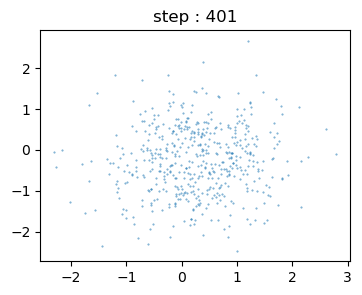

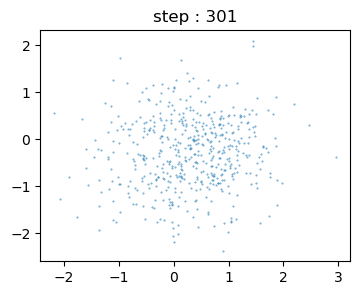

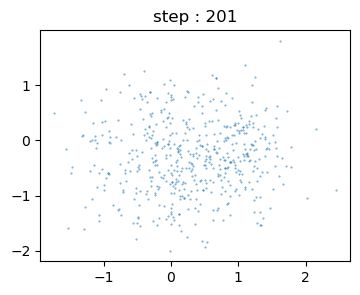

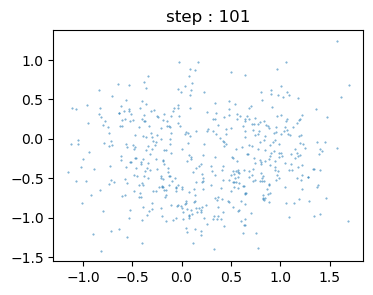

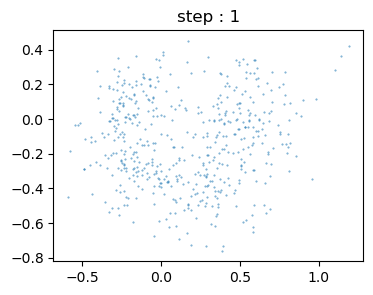

In [50]:
result = generate_batch(key, parameters, time_indices = time_indices)